# Comparing Similarities

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
import ast
from tqdm import tqdm

Plotting some similarities as boxplots:

In [2]:
# using a subset of the similarity measures

similarity_measure_names = ["js_divergence", 
                          "wasserstein_distance",  
                          "hellinger_distance",
                          "total_variation",
                          "chi2_distance", 
                          "histogram_correlation", 
                          "histogram_intersection"]

similarity_short = ["jsd", "wsd",  "hd", "tv", "chi2", "hc", "hi"]

In [3]:
# open stored similarity
def get_similarity(s_measure_name, s_measure_short, layer, variable):
                
    myFile = open(f'4b Similarities/{s_measure_name}/{layer}_{variable}_{s_measure_short}_similarities.txt', 'r')
    similarity = myFile.read()
    similarity = ast.literal_eval(similarity) 
    
    return similarity

In [4]:

# plotting similarities
def boxplotting(similarities, similarity_name):

    similarities_boxes = []
    c_names = []

    for name in similarities.keys():
        if name not in ["within_WTs","within_conditions","between_WTs_and_RSN","between_WT_datasets"]:
            similarities_boxes.append(similarities[name])
            c_names.append(name)

    
    
    fig, ax = plt.subplots()
    ax.set_ylabel(similarity_name)
    bplot = ax.boxplot(similarities_boxes)
    plt.xticks(range(1,len(c_names)+1), c_names, rotation=70)
    plt.show()

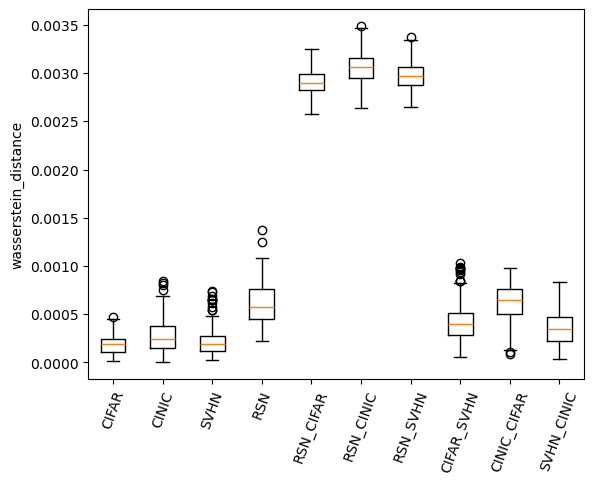

In [5]:
similarities = get_similarity("wasserstein_distance", "wsd", "dense1", "prune_rate_in")
boxplotting(similarities, "wasserstein_distance")

Plot means and stds:

In [6]:
similarity_statistics = pd.read_csv(f'4b Similarities/mean_std_similarities.csv').rename(columns = {"Unnamed: 0":"condition"}, inplace = False)

In [7]:
# displaying a selected area of the mean and std tables

similarity_statistics = similarity_statistics[similarity_statistics["similarity_measure"] == "wasserstein_distance"]
similarity_statistics = similarity_statistics[similarity_statistics["layer"] == "dense1"]
similarity_statistics = similarity_statistics[similarity_statistics["variable"] == "prune_rate_in"]
display(similarity_statistics)

,condition,mean,std,layer,variable,similarity_measure
112,CIFAR,0.000191,0.000099,dense1,prune_rate_in,wasserstein_distance
113,CINIC,0.000291,0.000188,dense1,prune_rate_in,wasserstein_distance
114,SVHN,0.000233,0.000169,dense1,prune_rate_in,wasserstein_distance
115,RSN,0.000620,0.000239,dense1,prune_rate_in,wasserstein_distance
116,RSN_CIFAR,0.002907,0.000124,dense1,prune_rate_in,wasserstein_distance
117,RSN_CINIC,0.003058,0.000156,dense1,prune_rate_in,wasserstein_distance
118,RSN_SVHN,0.002973,0.000136,dense1,prune_rate_in,wasserstein_distance
119,CIFAR_SVHN,0.000419,0.000187,dense1,prune_rate_in,wasserstein_distance
120,CINIC_CIFAR,0.000621,0.000194,dense1,prune_rate_in,wasserstein_distance
121,SVHN_CINIC,0.000357,0.000161,dense1,prune_rate_in,wasserstein_distance


Display t-test results:

In [8]:
test_results = pd.read_csv(f'4b Similarities/significance_test_results.csv')

In [9]:
def hypothesis_tables(results, layers):
    
    new_dfs = []
    for layer in layers:

        results_l = results[results["layer"] == layer]
        
        # make new dataframe with the indexi
        new_df = results_l[results_l["similarity_measure"] == "wasserstein_distance"][["variable","hypothesis"]]
        new_df = new_df.reset_index(drop=True)

        # apppend test results to dataframe
        for sm, sm_short in zip(similarity_measure_names, similarity_short):
            df = results_l[results_l["similarity_measure"] == sm]
            df = df[["accepted", "p-value"]]
            df.rename(columns = {"accepted":f"accepted_{sm_short}", "p-value":f"p-value_{sm_short}"}, inplace = True)
            df = df.reset_index(drop=True)
            new_df = pd.concat([new_df, df], axis=1)

        new_df.set_index(["variable","hypothesis"])
        new_dfs.append(new_df)
        
        display(new_df)
        
    return new_dfs

In [36]:
similarity_measures_latex = ["$d_{JSD}$", 
                          "$d_{W}$",  
                          "$d_{H}$",
                          "$d_{TV}$",
                          "$d_{{\chi}^{2}}$", 
                          "$h_{C}$", 
                          "$h_{\cap}$"]

def hypothesis_tables_latex(results):
    
    new_dfs = []
    for hypothesis in ["H1","H2","H3","H4"]:

        results_l = results[results["hypothesis"] == hypothesis]
        
        # make new dataframe with the indexi
        new_df = results_l[results_l["similarity_measure"] == "wasserstein_distance"][["variable","layer"]]
        new_df = new_df.reset_index(drop=True)

        # apppend test results to dataframe
        for sm, sm_short in zip(similarity_measure_names, similarity_measures_latex):
            df = results_l[results_l["similarity_measure"] == sm]
            #df = df[["accepted","p-value"]]
            #df.rename(columns = {"accepted":"a","p-value":f"{sm_short}"}, inplace = True)
            #df = df[f"{sm_short}"]
            df = df.reset_index(drop=True)
            
            # display each number as "%.3g" % and with \cellcolor{blue!25}
            latex_df = []
            for p in df["p-value"]:
                p = "%.3g" % p 
                if float(p) <= 0.05:
                    p = "\cellcolor{blue!25}" + p
                latex_df.append(p)
            latex_df = pd.Series(latex_df, name=sm_short)

            new_df = pd.concat([new_df, latex_df], axis=1)
        
        # sort by variable

        new_df.set_index(["variable","layer"])
        new_dfs.append(new_df)
        
        print("table for ", hypothesis)
        print(new_df.to_latex(index=False))
        
    return new_dfs

In [37]:
# adapted for Latex

def count_hypothesis_accepted(tables):
    
    h_count_tables= []
    for table in tables:
        # get the column names of the accepted values
        column_names = []
        for sm_short in similarity_short:
            column_names.append("accepted_"+sm_short)

        # get the counts for each variable and hypothesis combination
        accepted_counts = []
        for index, row in table.iterrows():
            accepted = []
            for c in column_names:
                accepted.append(row[c])
            accepted_counts.append(np.sum(accepted))

        # turn into pandas series and append to dataframe
        counts = pd.Series(accepted_counts, index=range(16))
        h_counts = pd.concat([table[["variable","hypothesis"]], counts], axis=1)
        h_count_tables.append(h_counts)
        
        # display dataframe
        display(h_counts)
        
    return h_count_tables

In [38]:
# print tables

tables = hypothesis_tables_latex(test_results)
#h_counts = count_hypothesis_accepted(tables)

table for  H1
\begin{tabular}{lllllllll}
\toprule
variable & layer & $d_{JSD}$ & $d_{W}$ & $d_{H}$ & $d_{TV}$ & $d_{{\chi}^{2}}$ & $h_{C}$ & $h_{\cap}$ \\
\midrule
prune_rate_in & dense1 & \cellcolor{blue!25}6.95e-83 & \cellcolor{blue!25}0 & \cellcolor{blue!25}1.79e-76 & \cellcolor{blue!25}0 & \cellcolor{blue!25}3.43e-88 & 1 & \cellcolor{blue!25}4.92e-107 \\
prune_rate_out & dense1 & \cellcolor{blue!25}7.25e-144 & \cellcolor{blue!25}0 & \cellcolor{blue!25}7.32e-174 & \cellcolor{blue!25}2.57e-193 & \cellcolor{blue!25}1.41e-145 & \cellcolor{blue!25}9.62e-16 & \cellcolor{blue!25}3.6e-158 \\
sign_rate_in & dense1 & \cellcolor{blue!25}1.32e-08 & \cellcolor{blue!25}7.51e-102 & \cellcolor{blue!25}8.58e-09 & \cellcolor{blue!25}8.87e-05 & \cellcolor{blue!25}1.96e-08 & \cellcolor{blue!25}0.0015 & \cellcolor{blue!25}1.95e-08 \\
sign_rate_out & dense1 & 1 & \cellcolor{blue!25}5.83e-113 & 1 & \cellcolor{blue!25}0.00482 & 1 & 1 & 0.825 \\
prune_rate_in & dense2 & \cellcolor{blue!25}5.04e-60 & \cellc

In [ ]:
# store tables

tables[0].to_csv(f'4b Similarities/hypotheses_table_dense1.csv', index=True)
tables[1].to_csv(f'4b Similarities/hypotheses_table_dense2.csv', index=True)
h_counts[0].to_csv(f'4b Similarities/hypotheses_counts_dense1.csv', index=True)
h_counts[1].to_csv(f'4b Similarities/hypotheses_counts_dense2.csv', index=True)

Hypothesis:  

1. Distances within WTs are smaller than between WTs and RSNs
2. Distances within RSNs are smaller than between WTs and RSNs
3. Distances within WTs are smaller than between WT datasts
4. Distances between WT datasets are smaller than between WTs and RSNs